<a href="https://colab.research.google.com/github/hyunholee26/Martian-Challenge/blob/main/Martian_Challenge_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/library'
os.symlink('/content/drive/My Drive/My Drive/pre-installed-library/', my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


In [2]:
import torch
import cv2
import json
import math
import copy
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [10]:
# install pycocotools
!pip install -U pycocotools

# download the demo dataset. 
!wget -O geoai_demo.zip https://www.dropbox.com/s/zmmonm9ijrm4u9y/geoai_demo.zip?dl=1

# extract it to the current folder and remove the zip file
!unzip -qo geoai_demo.zip && rm geoai_demo.zip

# list files and directories
!ls ./demo/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-12 12:52:46--  https://www.dropbox.com/s/zmmonm9ijrm4u9y/geoai_demo.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zmmonm9ijrm4u9y/geoai_demo.zip [following]
--2022-06-12 12:52:46--  https://www.dropbox.com/s/dl/zmmonm9ijrm4u9y/geoai_demo.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4c8fb14ba6e443f8926b39873.dl.dropboxusercontent.com/cd/0/get/BnEe5kq-JMkwtz-u7nT2BJ-zH8FtFAnJZ1hAz3gKmPYT03BBUu1ViaDb-dKzEg7mtL83Z0-cZB_mzyafxeyeFaindU5JqmtDYzaKXgUYFpMrzKb2tlId7LzXjlZLflBEFBoK5-rxS4w4gJneRvS-JBCK589cmg4akRN8xG0r6qMk-A/file?dl=1# [following]
--2022-06-12 12:52:46--  https://ucc4c8fb14ba6e443f8926b39

{'train': ['101398', '018197', '036424', '046139', '055557', '039019', '054921', '029306', '040505', '059359', '041615', '020869', '046308', '053302', '034169', '015420', '054248', '047588', '072908', '035022', '010851', '102002', '087819', '013947', '036086', '057256', '085792', '040800', '002737', '000243', '070652', '013517', '091555', '089559', '086485', '052741', '087377', '007803', '095084', '074699', '033233', '068584', '012702', '072390', '073172', '011461', '008149', '097663', '010789', '058912', '101414', '018102', '023941', '071570', '038160', '077788', '040767', '036618', '058242', '088954', '082852', '038310', '014934', '058620', '050481', '056414', '029034', '099956', '050505', '022230', '101124', '010535', '088627', '025906', '032088', '094096', '034425', '031133', '024938', '011118', '049459', '025684', '081903', '052280', '035777', '088139', '021100', '051940', '031985', '016696', '054833', '051282', '046641', '059494', '034843', '075594', '073789', '022438', '041516',

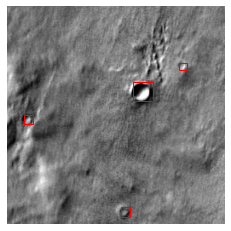

In [11]:
path = './demo/'

# function to show one image and its crater labels
def imshow(image, labels):
  fig, ax = plt.subplots()
  ax.imshow(image, cmap='gray')

  for box in labels:
    # box format: [xmin, ymin, width, height]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  plt.axis('off')
  plt.show()

# load image IDs from ids_demo.json
image_ids = json.load(open(path + "./ids_demo.json"))
print(image_ids)

# get IDs of the training set
train_set_ids = image_ids["train"]
print(train_set_ids)

# load one sample image
sample_image_id = train_set_ids[random.randrange(len(train_set_ids))]
sample_image = cv2.imread(path + "./images/{}.png".format(sample_image_id))

# load crater labels from gt_public.json
labels = json.load(open(path + "./gt_public.json"))

# load the label for the sample image 
sample_label = labels[sample_image_id]
print("image id: {}".format(sample_image_id))
imshow(sample_image, sample_label)

In [12]:
def get_object_detection_model(num_classes):
  model = models.detection.retinanet_resnet50_fpn(num_classes=num_classes)
  return model

In [15]:
class CraterDataset(Dataset):
  def __init__(self, phase, data_transforms):
    self.transform = data_transforms
    # load image IDs of training set or validation set
    self.img_ids = json.load(open(path + './ids_demo.json'))[phase]
    # load all crater bounding boxes
    self.crater_boxes = json.load(open(path + './gt_public.json'))


  def __getitem__(self, idx): 
    img_id = self.img_ids[idx]
    # load the image
    img = cv2.imread(path + "./images/{}.png".format(img_id)) 
    # get bounding boxes and transfer it 
    # from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax] 
    crater_boxes = self.crater_boxes[img_id]
    num_craters = len(crater_boxes)
    boxes = []
    for box in crater_boxes:
        xmin = box[0]
        xmax = box[0] + box[2]
        ymin = box[1]
        ymax = box[1] + box[3]
        boxes.append([xmin, ymin, xmax, ymax])

    # tranfser to requested data type
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # the class of all boxes is the same. 0: background 1: crater
    labels = torch.ones((num_craters,), dtype=torch.int64)
    # wrap up as a dictionary 
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    # data transform 
    if self.transform is not None:
        img = self.transform(img)

    return img, target
    
  
  def __len__(self):
    return len(self.img_ids)

In [16]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [17]:
def train_model(model, optimizer, dataset, data_loader, num_epochs=10):
  since = time.time()
  # check if gpu is available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  print('training with gpu...' if torch.cuda.is_available() else 'trining with cpu...')
  # store best model weights
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100000
  model.train()

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      running_loss = 0.0

      # iterate over data
      for images, targets in data_loader[phase]:
        # transfer data into requested input format of RetinaNet
        # transfer data to gpu if available
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # loss calculation
        losses = model(images, targets)
        losses = sum(loss for loss in losses.values())

        # update the model only in the training phase
        # gradient back propagation + model parameters update
        if phase == 'train':
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        # accumulate loss values
        running_loss += losses.item() * len(images)
      
      # average loss   
      epoch_loss = running_loss / len(dataset[phase])
      print('{} loss: {:.4f}'.format(phase, epoch_loss))

      # select the best model in the validation phase
      # copy the model weights if loss is smaller
      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
          
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best validation loss: {:4f}'.format(best_loss))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
# initialize a model with numer of classes = 2
model = get_object_detection_model(2)

# define data tranformation function
data_transforms = transforms.Compose([transforms.ToTensor()])

# define dataset and dataloader for training for debug set
dataset = {x: CraterDataset(x, data_transforms) for x in ['train', 'val']}
data_loader = {x: DataLoader(dataset[x], batch_size=8, 
                             shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
for x in ['train', 'val']}

# transfer the model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# define optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train model
model = train_model(model, optimizer, dataset, data_loader, num_epochs=20)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

training with gpu...
Epoch 0/19
----------
train loss: 1.8505
val loss: 1.8338

Epoch 1/19
----------
train loss: 1.7981
val loss: 1.7135

Epoch 2/19
----------
train loss: 1.6546
val loss: 1.5777

Epoch 3/19
----------
train loss: 1.5567
val loss: 1.5920

Epoch 4/19
----------
train loss: 1.4732
val loss: 1.2391

Epoch 5/19
----------
train loss: 1.5320
val loss: 1.6347

Epoch 6/19
----------
train loss: 1.6204
val loss: 1.6001

Epoch 7/19
----------
train loss: 1.5669
val loss: 1.3902

Epoch 8/19
----------
train loss: 1.3554
val loss: 1.6914

Epoch 9/19
----------
train loss: 1.6504
val loss: 1.6193

Epoch 10/19
----------
train loss: 1.6273
val loss: 1.6150

Epoch 11/19
----------
train loss: 1.6215
val loss: 1.6130

Epoch 12/19
----------
train loss: 1.6181
val loss: 1.6078

Epoch 13/19
----------
train loss: 1.6146
val loss: 1.6046

Epoch 14/19
----------
train loss: 1.6087
val loss: 1.5958

Epoch 15/19
----------
train loss: 1.5928
val loss: 1.5598

Epoch 16/19
----------


In [ ]:
# set the model in the evaluation model
model.eval()

# load testing image IDs
test_img_ids = json.load(open(path + './ids_demo.json'))['test']

# load one sample image
test_img_id = test_img_ids[random.randrange(len(test_img_ids))]
test_img = cv2.imread(path + './images/{}.png'.format(test_img_id))

# apply data transformation ToTensor() and send the image to gpu if available
transformed_test_img = data_transforms(test_img)
transformed_test_img = transformed_test_img.to(device)

# turn of the gradient computation and make prediction
with torch.no_grad():
  prediction = model([transformed_test_img])

# keep boxes with scores >= 0.5
boxes = prediction[0]["boxes"]
scores = prediction[0]["scores"]
boxes = boxes[scores >= 0.5, :]

# box format transformation
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

# plot image
print("image id: {}".format(test_img_id))
imshow(test_img, boxes)

In [ ]:
# set the model in evaluation model                                
model.eval()

# load image IDs of the validation set
val_img_ids = json.load(open(path + './ids_demo.json'))['val']
detection_results = {}

# iterate over the validation set
for img_id in val_img_ids:
  val_img = cv2.imread(path + './images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_val_img = data_transforms(val_img)
  transformed_val_img = transformed_val_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_val_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores

# import evaluate function
from evaluate import evaluate
print('evaluation metrics: ')
metrics = evaluate(detection_results, val_img_ids)
print()
print('the list of evaluation values: {}'.format(metrics))

In [ ]:
# set the model in evaluation model                                
model.eval()
# load image IDs of the testing set
test_img_ids = json.load(open('./ids_demo.json'))['test']
detection_results = {}

# iterate over the testing set
for img_id in test_img_ids:
  test_img = cv2.imread('./images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_test_img = data_transforms(test_img)
  transformed_test_img = transformed_test_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_test_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores

# save the result to file
with open('detection_results.json', 'w') as f:
  json.dump(detection_results, f)

# zip the result
!zip detection_results.zip detection_results.json